# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)


import math
import json
import seaborn as sns; sns.set()
sns.set_style('white')


from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, classification_report
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. EDA And Data Cleaning

In this notebook, we will be predicting whether someone will complete a particular offer, given the offer characteristics and the person's demographic.

## 1.1 Portfolio

In [4]:
display(portfolio.head())

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio['channels'] = portfolio['channels'].apply(lambda x: np.array(x))

# Transform the channels
for channel in ['email','web','mobile','social']:
    portfolio['is_{}'.format(channel)] = portfolio['channels'].apply(lambda x: channel in x)
    
portfolio = portfolio.drop(['channels'], axis=1)

portfolio = portfolio.rename(columns={
    'id' : 'offer_id'
})

display(portfolio.head())

,difficulty,duration,offer_id,offer_type,reward,is_email,is_web,is_mobile,is_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,True,False,True,True
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,True,True,True,True
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,True,True,True,False
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,True,True,True,False
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,True,True,False,False


## 1.2 Profile

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


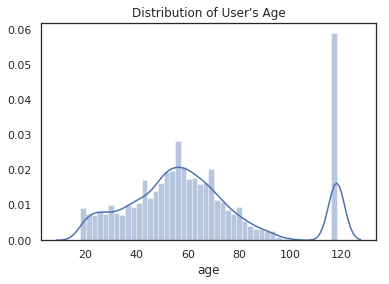

In [7]:
plt.figure()
plt.title('Distribution of User\'s Age')
sns.distplot(profile['age'])
plt.show()

Looks like 118 is used to encode a missing age, and hence will be dropped.

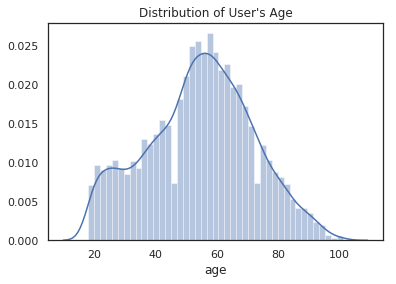

In [8]:
profile['age'] = profile['age'].replace(118, np.NaN)

plt.figure()
plt.title('Distribution of User\'s Age')
sns.distplot(profile['age'].dropna())
plt.show()

In [9]:
profile['row_missing_count'] = profile[['age', 'gender', 'income']].isnull().sum(axis=1)

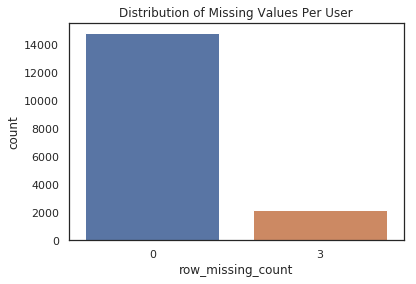

In [10]:
plt.figure()
plt.title('Distribution of Missing Values Per User')
sns.countplot(profile['row_missing_count'])
plt.show()

It seems that in the data, user either have complete data or all missing data. 

If we are to impute the data, these ~2k users will provide no additional information as their values will be all the same. 

We will proceed by dropping these users from the analysis.

In [11]:
profile = profile[profile['row_missing_count'] == 0]

In [12]:
profile = profile.drop(['row_missing_count'], axis=1)
profile = profile.rename(columns={
    'id' : 'profile_id'
})

In [13]:
print(profile['became_member_on'].max())

ref_date = '20190101'

profile['ref_date'] = '20190101'

20180726


In [14]:
profile['became_member_on'] = profile['became_member_on'].astype(str)
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])
profile['ref_date'] = pd.to_datetime(profile['ref_date'])

In [15]:
profile['tenure'] = profile['ref_date'] - profile['became_member_on']
profile['tenure'] = profile['tenure'].astype('timedelta64[D]')

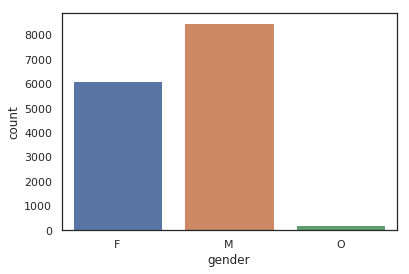

In [16]:
sns.countplot(profile['gender'])

In [17]:
profile = profile[profile['gender'] != 'O']

In [18]:
gender_dummy_df = pd.get_dummies(profile['gender'], drop_first=True)

profile = profile.join(gender_dummy_df)

In [19]:
profile = profile.drop(['gender'], axis=1)
profile = profile.drop(['became_member_on', 'ref_date'], axis=1)

In [20]:
display(profile.head())

,age,profile_id,income,tenure,M
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,535.0,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,602.0,0
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,250.0,1
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,326.0,1
12,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,416.0,1


## 1.3. Transcript

In [21]:
display(transcript.head())

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [22]:
transcript = transcript.rename(columns={
    'person' : 'profile_id'
})

In [23]:
print(transcript['event'].drop_duplicates().values)

['offer received' 'offer viewed' 'transaction' 'offer completed']


In [24]:
received_df = transcript[transcript['event'] == 'offer received']
viewed_df = transcript[transcript['event'] == 'offer viewed']
completed_df = transcript[transcript['event'] == 'offer completed']
txn_df = transcript[transcript['event'] == 'transaction']

### 1.3.1 Offer Received Event

In [25]:
display(received_df.head())

,event,profile_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [26]:
received_df['offer_id'] = received_df['value'].apply(lambda x: x['offer id'])

In [27]:
received_df = received_df.rename(columns={
    'time' : 'received_time'
})

received_df = received_df.drop(['event', 'value'], axis=1)

In [28]:
received_df = received_df.merge(portfolio, on=['offer_id'])

In [29]:
received_df['expiry_time'] = received_df['received_time'] + 24 * received_df['duration']
received_df['expiry_time'] = received_df['expiry_time'].astype(int)

In [30]:
display(received_df.head())

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168


### 1.3.2 Offer Viewed Event

In [31]:
display(viewed_df.head())

,event,profile_id,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [32]:
viewed_df['offer_id'] = viewed_df['value'].apply(lambda x: x['offer id'])

In [33]:
viewed_df = viewed_df.rename(columns={
    'time' : 'viewed_time'
})


viewed_df['viewed_time'] = viewed_df['viewed_time'].astype(int)


viewed_df = viewed_df.drop(['event', 'value'], axis=1)

In [34]:
display(viewed_df.head())

,profile_id,viewed_time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


### 1.3.3 Offer Completed Event

In [35]:
display(completed_df.head())

,event,profile_id,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [36]:
completed_df['offer_id'] = completed_df['value'].apply(lambda x: x['offer_id'])

In [37]:
completed_df = completed_df.rename(columns={
    'time' : 'completed_time'
})


completed_df['completed_time'] = completed_df['completed_time'].astype(int)


completed_df = completed_df.drop(['event', 'value'], axis=1)

In [38]:
display(completed_df.head())

,profile_id,completed_time,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0


### 1.3.4 Combining Received and Viewed Event

In [39]:
receive_and_view = received_df.merge(viewed_df, on=['profile_id', 'offer_id'], how='left')

In [40]:
print(len(receive_and_view))
print(len(viewed_df))

95321
57725


In [41]:
receive_and_view = receive_and_view[
    (receive_and_view['viewed_time'] >= receive_and_view['received_time'])
]

In [42]:
print(len(receive_and_view))
print(len(viewed_df))

68404
57725


Some view event are still assigned to more than 1 received event.

In [43]:
view_count = receive_and_view.groupby(['profile_id', 'offer_id', 'viewed_time'])['received_time'].count().reset_index()

duplicated_view_count = view_count[view_count['received_time'] > 1].sort_values(by='received_time', ascending=False)

non_duplicated_view_count = view_count[view_count['received_time'] == 1]

display(duplicated_view_count.head())

duplicated_view_count = duplicated_view_count[['profile_id', 'offer_id', 'viewed_time']]
non_duplicated_view_count = non_duplicated_view_count[['profile_id', 'offer_id', 'viewed_time']]

,profile_id,offer_id,viewed_time,received_time
53868,eece6a9a7bdd4ea1b0f812f34fc619d6,5a8bc65990b245e5a138643cd4eb9837,576.0,5
10189,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,576.0,5
7653,23d67a23296a485781e69c109a10a1cf,5a8bc65990b245e5a138643cd4eb9837,582.0,5
24531,6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,588.0,5
42113,b993a783cfe844848fc165a1de3926b1,3f207df678b143eea3cee63160fa8bed,582.0,4


In [44]:
display(receive_and_view.merge(duplicated_view_count.head(1)[['profile_id', 'offer_id']], on=['profile_id', 'offer_id']))

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time
0,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,72,90.0
1,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,72,174.0
2,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,72,414.0
3,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,72,516.0
4,eece6a9a7bdd4ea1b0f812f34fc619d6,0,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,72,576.0
5,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,240,174.0
6,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,240,414.0
7,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,240,516.0
8,eece6a9a7bdd4ea1b0f812f34fc619d6,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,240,576.0
9,eece6a9a7bdd4ea1b0f812f34fc619d6,408,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,True,480,414.0


In [45]:
non_duplicated_views = receive_and_view.merge(non_duplicated_view_count, on=['profile_id', 'offer_id', 'viewed_time'])
non_duplicated_views['not_duplicated'] = 1
checker_viewed = non_duplicated_views[['profile_id', 'offer_id', 'received_time', 'not_duplicated']].drop_duplicates()

duplicated_views = receive_and_view.merge(duplicated_view_count, on=['profile_id', 'offer_id', 'viewed_time'])
duplicated_views = duplicated_views.merge(checker_viewed, on=['profile_id','offer_id','received_time'], how='left')
duplicated_views['not_duplicated'] = duplicated_views['not_duplicated'].fillna(0)
duplicated_views = duplicated_views[duplicated_views['not_duplicated'] == 0]

In [46]:
duplicated_views.head()

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time,not_duplicated
0,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168,714.0,0.0
1,ebe7ef46ea6f4963a7dd49f501b26779,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,744,714.0,0.0
3,32fbf97e89274e8a935903f2ad095e1f,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,504,360.0,0.0
5,d1a6fe4c241e4dbf8a4da6fd6c714ac5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,336,192.0,0.0
6,bbeb54e861614fc7b22a8844f72dca6c,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168,528.0,0.0


In [47]:
duplicated_views['same_offer_receive_order'] = duplicated_views.sort_values(by='received_time', ascending=False).groupby(['profile_id', 'offer_id'])['received_time'].rank(method='dense')
duplicated_views['same_offer_view_order'] = duplicated_views.sort_values(by='viewed_time', ascending=True).groupby(['profile_id', 'offer_id'])['viewed_time'].rank(method='dense')

In [48]:
fixed_duplicated_views = duplicated_views[
    (duplicated_views['same_offer_receive_order'] == duplicated_views['same_offer_view_order'])
]

fixed_duplicated_views = fixed_duplicated_views.drop(['same_offer_receive_order', 'same_offer_view_order'], axis=1)

In [49]:
receive_and_view = pd.concat([non_duplicated_views, fixed_duplicated_views])

In [50]:
check_view_df = receive_and_view.groupby(['profile_id', 'offer_id', 'viewed_time'])['received_time'].count().reset_index()
check_view_df_2 = receive_and_view.groupby(['profile_id', 'offer_id', 'received_time'])['viewed_time'].count().reset_index()

display(check_view_df.sort_values(by=['received_time'], ascending=False).head())
display(check_view_df_2.sort_values(by=['viewed_time'], ascending=False).head())

,profile_id,offer_id,viewed_time,received_time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,1
38447,a97e140cf0094644a99290c1172f7d18,2906b810c7d4411798c6938adc9daaa5,378.0,1
38477,a99e6dc6e2db4882a07f4280db7de088,ae264e3637204a6fb9bb56bc8210ddfd,528.0,1
38478,a99e6dc6e2db4882a07f4280db7de088,f19421c1d4aa40978ebb69ca19b0e20d,594.0,1
38479,a99e6dc6e2db4882a07f4280db7de088,fafdcd668e3743c1bb461111dcafc2a4,450.0,1


,profile_id,offer_id,received_time,viewed_time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,1
38447,a97e140cf0094644a99290c1172f7d18,2906b810c7d4411798c6938adc9daaa5,336,1
38477,a99e6dc6e2db4882a07f4280db7de088,ae264e3637204a6fb9bb56bc8210ddfd,504,1
38478,a99e6dc6e2db4882a07f4280db7de088,f19421c1d4aa40978ebb69ca19b0e20d,576,1
38479,a99e6dc6e2db4882a07f4280db7de088,fafdcd668e3743c1bb461111dcafc2a4,408,1


In [51]:
print(len(receive_and_view))
print(len(viewed_df))

57725
57725


In [52]:
receive_and_view = receive_and_view[['profile_id', 'received_time', 'offer_id', 'viewed_time']]

### 1.3.5 Combining Received and Completed Event

In [53]:
completed_df['dummy_count'] = 1

In [54]:
display(completed_df.groupby(['profile_id', 'offer_id', 'completed_time'])['dummy_count']\
        .sum().sort_values(ascending=False).reset_index().head())

,profile_id,offer_id,completed_time,dummy_count
0,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,3
1,6fa9ef8890bc467699ce92f2679a4178,f19421c1d4aa40978ebb69ca19b0e20d,624,2
2,9b2ec72a4ee04bb1bbf360642f22e7d3,fafdcd668e3743c1bb461111dcafc2a4,630,2
3,b669b308d4fa4bff837d68d86a78e6b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,510,2
4,d19849e046cc441fb7cfc4c8a68dbf6d,0b1e1539f2cc45b7b9fa7c272da2e1d7,600,2


In [55]:
completed_df['dummy_rank'] = completed_df.groupby(['profile_id', 'offer_id', 'completed_time'])['dummy_count'].rank(method='first')

completed_df['dummy_completed_time'] = completed_df['completed_time'] + completed_df['dummy_rank'] / 10

A person can receive multiple instances of the same offers, and completes all of them at the same time.

In [56]:
receive_and_complete = received_df.merge(completed_df, on=['profile_id', 'offer_id'])

In [57]:
receive_and_complete = receive_and_complete[
    (receive_and_complete['completed_time'] >= receive_and_complete['received_time']) &
    (receive_and_complete['completed_time'] <= receive_and_complete['expiry_time'])
]

In [58]:
print(len(receive_and_complete))
print(len(completed_df))

35376
33579


In [59]:
complete_count = receive_and_complete.groupby(['profile_id', 'offer_id', 'completed_time'])['received_time'].count().reset_index()

duplicated_complete_count = complete_count[complete_count['received_time'] > 1].sort_values(by='received_time', ascending=False)

non_duplicated_complete_count = complete_count[complete_count['received_time'] == 1]

display(duplicated_complete_count.head())

duplicated_complete_count = duplicated_complete_count[['profile_id', 'offer_id', 'completed_time']]
non_duplicated_complete_count = non_duplicated_complete_count[['profile_id', 'offer_id', 'completed_time']]

,profile_id,offer_id,completed_time,received_time
6860,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,9
6920,35b3206b05304a518114bee3e113af09,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,6
5994,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,528,6
11731,5a7136999fa240838c28e52359f6533d,fafdcd668e3743c1bb461111dcafc2a4,618,6
19873,99148a450059428180ed37cb9ab01f62,2906b810c7d4411798c6938adc9daaa5,642,4


In [60]:
display(receive_and_complete.merge(duplicated_complete_count.head(1)[['profile_id', 'offer_id']], on=['profile_id', 'offer_id']))

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,completed_time,dummy_count,dummy_rank,dummy_completed_time
0,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,576,510,1,1.0,510.1
1,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,576,510,1,2.0,510.2
2,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,576,510,1,3.0,510.3
3,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,648,510,1,1.0,510.1
4,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,648,510,1,2.0,510.2
5,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,648,510,1,3.0,510.3
6,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,744,510,1,1.0,510.1
7,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,744,510,1,2.0,510.2
8,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,744,510,1,3.0,510.3


In [61]:
non_duplicated_completes = receive_and_complete.merge(non_duplicated_complete_count, on=['profile_id', 'offer_id', 'completed_time'])
non_duplicated_completes['not_duplicated'] = 1


checker_completed = non_duplicated_completes[['profile_id', 'offer_id', 'received_time', 'not_duplicated']].drop_duplicates()

duplicated_completes = receive_and_complete.merge(duplicated_complete_count, on=['profile_id', 'offer_id', 'completed_time'])
duplicated_completes = duplicated_completes.merge(checker_completed, on=['profile_id','offer_id','received_time'], how='left')

duplicated_completes['not_duplicated'] = duplicated_completes['not_duplicated'].fillna(0)
duplicated_completes = duplicated_completes[duplicated_completes['not_duplicated'] == 0]

In [62]:
duplicated_completes['same_offer_receive_order'] = duplicated_completes.sort_values(by='received_time', ascending=True).groupby(['profile_id', 'offer_id'])['received_time'].rank(method='dense')

duplicated_completes['same_offer_complete_order'] = duplicated_completes.sort_values(by='dummy_completed_time', ascending=True).groupby(['profile_id', 'offer_id'])['dummy_completed_time'].rank(method='dense')

In [63]:
duplicated_completes[duplicated_completes['profile_id'] == '3526938fb466470190a504a751ec07b0']

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,completed_time,dummy_count,dummy_rank,dummy_completed_time,not_duplicated,same_offer_receive_order,same_offer_complete_order
434,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,576,510,1,1.0,510.1,0.0,1.0,1.0
435,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,576,510,1,2.0,510.2,0.0,1.0,2.0
436,3526938fb466470190a504a751ec07b0,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,576,510,1,3.0,510.3,0.0,1.0,3.0
437,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,648,510,1,1.0,510.1,0.0,2.0,1.0
438,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,648,510,1,2.0,510.2,0.0,2.0,2.0
439,3526938fb466470190a504a751ec07b0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,648,510,1,3.0,510.3,0.0,2.0,3.0
440,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,744,510,1,1.0,510.1,0.0,3.0,1.0
441,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,744,510,1,2.0,510.2,0.0,3.0,2.0
442,3526938fb466470190a504a751ec07b0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,True,True,False,False,744,510,1,3.0,510.3,0.0,3.0,3.0


In [64]:
fixed_duplicated_completes = duplicated_completes[
    (duplicated_completes['same_offer_receive_order'] == duplicated_completes['same_offer_complete_order'])
]

fixed_duplicated_completes = fixed_duplicated_completes.drop(['same_offer_receive_order', 'same_offer_complete_order'], axis=1)

In [65]:
receive_and_complete = pd.concat([non_duplicated_completes, fixed_duplicated_completes])

In [66]:
check_complete_df = receive_and_complete.groupby(['profile_id', 'offer_id', 'completed_time'])['received_time'].count().reset_index()
check_complete_df_2 = receive_and_complete.groupby(['profile_id', 'offer_id', 'received_time'])['completed_time'].count().reset_index()

display(check_complete_df.sort_values(by=['received_time'], ascending=False).head())
display(check_complete_df_2.sort_values(by=['completed_time'], ascending=False).head())

,profile_id,offer_id,completed_time,received_time
6860,3526938fb466470190a504a751ec07b0,0b1e1539f2cc45b7b9fa7c272da2e1d7,510,3
18099,8b9d3f738e7e499b9e820de07c16bc62,2906b810c7d4411798c6938adc9daaa5,630,2
13727,69743d51492d4173b0e054fd5d8f943c,f19421c1d4aa40978ebb69ca19b0e20d,576,2
14244,6d6c0aa032064438b97ab5dc28fd1b61,9b98b8c7a33c4b65b9aebfe6a799e6d9,432,2
2010,0f6cf9619c4341e89a099e951300a2ea,0b1e1539f2cc45b7b9fa7c272da2e1d7,552,2


,profile_id,offer_id,received_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,1
22396,a960ae2cd3d04791ac3ca5799a2ad01a,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1
22394,a95c94e9e8444d3ea4e10d2b96c6bba4,ae264e3637204a6fb9bb56bc8210ddfd,0,1
22393,a95c8b2d84b04c22b525d6fec9e1dda3,fafdcd668e3743c1bb461111dcafc2a4,336,1
22392,a95c8b2d84b04c22b525d6fec9e1dda3,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,1


In [67]:
print(len(receive_and_complete))
print(len(completed_df))

33579
33579


In [68]:
receive_and_complete = receive_and_complete[['profile_id', 'received_time', 'offer_id', 'completed_time']]

In [69]:
experiment_df = received_df.merge(receive_and_view, on=['profile_id', 'received_time', 'offer_id'], how='left')\
    .merge(receive_and_complete, on=['profile_id', 'received_time', 'offer_id'], how='left')

In [70]:
experiment_df['is_viewed'] = pd.notnull(experiment_df['viewed_time'])
experiment_df['is_completed'] = pd.notnull(experiment_df['completed_time'])

In [71]:
display(experiment_df.head())

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,is_social,expiry_time,viewed_time,completed_time,is_viewed,is_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168,6.0,132.0,True,True
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168,714.0,NaN,True,False
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168,48.0,12.0,True,True
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168,30.0,66.0,True,True
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,False,168,NaN,NaN,False,False


### 1.3.6 Transactions Data

In [72]:
display(txn_df.head())

,event,profile_id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [73]:
txn_df['amount'] = txn_df['value'].apply(lambda x: x['amount'])

In [74]:
txn_df = txn_df.rename(columns={
    'time' : 'txn_time', 
})

txn_df = txn_df.drop(['event', 'value'], axis=1)

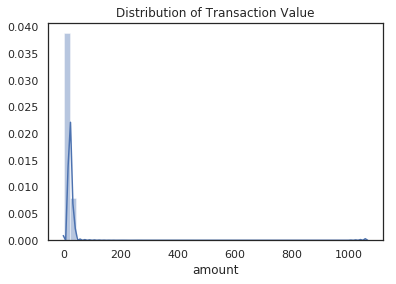

In [75]:
plt.figure()
plt.title('Distribution of Transaction Value')
sns.distplot(txn_df['amount'])
plt.show()

40.02


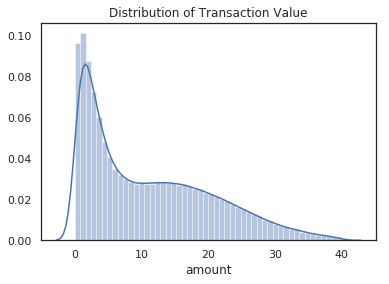

In [76]:
upper_lim  = np.percentile(txn_df['amount'], 99)
print(np.round(upper_lim, 2))

txn_df = txn_df[txn_df['amount'] <= upper_lim]


plt.figure()
plt.title('Distribution of Transaction Value')
sns.distplot(txn_df['amount'])
plt.show()

In [77]:
experiment_df[['profile_id', 'offer_id', 'received_time', 'viewed_time', 'completed_time', 'expiry_time']]\
    .groupby(['profile_id', 'offer_id', 'received_time', 'viewed_time', 'completed_time', 'expiry_time'])

In [78]:
exp_txns_df = experiment_df[['profile_id', 'offer_id', 'received_time', 'viewed_time', 'completed_time', 'expiry_time']]\
    .merge(txn_df, on=['profile_id'])
print(len(exp_txns_df))

632057


In [79]:
between_received_and_view = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
    &(exp_txns_df['txn_time'] <= exp_txns_df['viewed_time'])
    
between_view_and_complete = (exp_txns_df['txn_time'] >= exp_txns_df['viewed_time'])\
    &(exp_txns_df['txn_time'] <= exp_txns_df['completed_time'])

between_received_and_complete = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
    &(exp_txns_df['txn_time'] <= exp_txns_df['completed_time'])

between_received_and_expiry = (exp_txns_df['txn_time'] >= exp_txns_df['received_time'])\
    &(exp_txns_df['txn_time'] <= exp_txns_df['expiry_time'])

before_received = (exp_txns_df['txn_time'] < exp_txns_df['received_time'])


exp_txns_df['between_received_and_view_amount'] = np.where(between_received_and_view, exp_txns_df['amount'], 0)
exp_txns_df['between_view_and_complete_amount'] = np.where(between_view_and_complete, exp_txns_df['amount'], 0)
exp_txns_df['between_received_and_complete_amount'] = np.where(between_received_and_complete, exp_txns_df['amount'], 0)
exp_txns_df['between_received_and_expiry_amount'] = np.where(between_received_and_expiry, exp_txns_df['amount'], 0)
exp_txns_df['before_received_amount'] = np.where(before_received, exp_txns_df['amount'], 0)


exp_txns_df['between_received_and_view_count'] = np.where(between_received_and_view, 1, 0)
exp_txns_df['between_view_and_complete_count'] = np.where(between_view_and_complete, 1, 0)
exp_txns_df['between_received_and_complete_count'] = np.where(between_received_and_complete, 1, 0)
exp_txns_df['between_received_and_expiry_count'] = np.where(between_received_and_expiry, 1, 0)
exp_txns_df['before_received_count'] = np.where(before_received, 1, 0)

cols_to_be_summed = [i for i in exp_txns_df.columns if 'between' in i or 'before' in i]

In [80]:
exp_txns_df = exp_txns_df.groupby(['profile_id', 'offer_id', 'received_time'])[cols_to_be_summed]\
    .sum().reset_index()

In [81]:
full_data_df = experiment_df.merge(exp_txns_df, on=['profile_id', 'offer_id', 'received_time'], how='left')\
    .merge(profile, on=['profile_id'])

In [118]:
full_data_df['percent_completed_when_viewed'] = full_data_df['between_received_and_view_amount'] / full_data_df['difficulty']

In [119]:
for col in cols_to_be_summed:
    full_data_df[col] = full_data_df[col].fillna(0)

In [120]:
full_data_df.head()

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,...,between_received_and_view_count,between_view_and_complete_count,between_received_and_complete_count,between_received_and_expiry_count,before_received_count,age,income,tenure,M,percent_completed_when_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,...,0.0,1.0,1.0,2.0,0.0,75.0,100000.0,602.0,0,0.000
1,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,True,True,True,...,2.0,0.0,1.0,2.0,5.0,75.0,100000.0,602.0,0,9.656
2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,True,False,True,...,0.0,1.0,1.0,2.0,5.0,75.0,100000.0,602.0,0,0.000
3,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,True,False,True,...,0.0,0.0,0.0,2.0,2.0,75.0,100000.0,602.0,0,NaN
4,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,...,13.0,0.0,0.0,1.0,0.0,59.0,41000.0,1441.0,1,10.416


# Predicting who will complete the offer

In [121]:
full_data_df.groupby(['offer_type', 'offer_id']).agg({
    'received_time' : 'count',
    'is_viewed' : 'sum',
    'is_completed' : 'sum'
}).reset_index()

,offer_type,offer_id,received_time,is_viewed,is_completed
0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,6521,6258.0,3265.0
1,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,6584,3423.0,4114.0
2,bogo,ae264e3637204a6fb9bb56bc8210ddfd,6590,5818.0,3598.0
3,bogo,f19421c1d4aa40978ebb69ca19b0e20d,6488,6225.0,4036.0
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,6627,2161.0,3323.0
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,6563,6289.0,4819.0
6,discount,2906b810c7d4411798c6938adc9daaa5,6543,3395.0,3851.0
7,discount,fafdcd668e3743c1bb461111dcafc2a4,6564,6319.0,4937.0
8,informational,3f207df678b143eea3cee63160fa8bed,6561,3417.0,0.0
9,informational,5a8bc65990b245e5a138643cd4eb9837,6544,5782.0,0.0


In [122]:
viewed_df = full_data_df[(full_data_df['is_viewed']) & (full_data_df['offer_type'] != 'informational')]

In [123]:
viewed_df.head()

,profile_id,received_time,offer_id,difficulty,duration,offer_type,reward,is_email,is_web,is_mobile,...,between_received_and_view_count,between_view_and_complete_count,between_received_and_complete_count,between_received_and_expiry_count,before_received_count,age,income,tenure,M,percent_completed_when_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,...,0.0,1.0,1.0,2.0,0.0,75.0,100000.0,602.0,0,0.000
1,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,True,True,True,...,2.0,0.0,1.0,2.0,5.0,75.0,100000.0,602.0,0,9.656
2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,True,False,True,...,0.0,1.0,1.0,2.0,5.0,75.0,100000.0,602.0,0,0.000
4,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,True,True,True,...,13.0,0.0,0.0,1.0,0.0,59.0,41000.0,1441.0,1,10.416
6,ebe7ef46ea6f4963a7dd49f501b26779,408,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,True,True,True,...,1.0,2.0,3.0,7.0,6.0,59.0,41000.0,1441.0,1,0.249


In [124]:
features = ['difficulty', 'duration', 'reward', 'age', 'income', 'tenure', 
            'M', 'before_received_amount', 'percent_completed_when_viewed']

target_var = ['is_completed']

In [125]:
offer_type = 'bogo'

offer_df = viewed_df[viewed_df['offer_type'] == offer_type]

In [126]:
X = offer_df[features]
y = offer_df[target_var]

In [127]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) 

In [128]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 10, None],
    'min_samples_split' : [10, 50 , 100],
    'min_samples_leaf' : [10, 50, 100]
}

In [129]:
baseline_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                              param_grid=param_grid, cv=3, scoring='f1')

baseline_model.fit(X_train, y_train);
baseline_model.best_score_

0.8071731528682714

In [130]:
y_val_scores = baseline_model.predict_proba(X_val)
y_val_preds = baseline_model.predict(X_val)

In [131]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_scores[:, 1:])

In [132]:
thresholds_plot = np.zeros(len(precision))

In [133]:
thresholds_plot[1:] = thresholds

In [134]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

       False       0.74      0.75      0.74      1419
        True       0.82      0.82      0.82      2057

   micro avg       0.79      0.79      0.79      3476
   macro avg       0.78      0.78      0.78      3476
weighted avg       0.79      0.79      0.79      3476



In [135]:
print('Accuracy Score on Validation Set: ', accuracy_score(y_val, y_val_preds))
print('Precision Score on Validation Set: ', precision_score(y_val, y_val_preds))
print('Recall Score on Validation Set: ', recall_score(y_val, y_val_preds))
print('F1 Score on Validation Set', f1_score(y_val, y_val_preds))

Accuracy Score on Validation Set:  0.7914269275028769
Precision Score on Validation Set:  0.8245614035087719
Recall Score on Validation Set:  0.8225571220223626
F1 Score on Validation Set 0.8235580433195425


In [136]:
param_grid = {
    'n_estimators' : [50, 100, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 10, None],
    'min_samples_split' : [10, 50 , 100],
    'min_samples_leaf' : [10, 50, 100]
}

In [137]:
model = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                              param_grid=param_grid, cv=3, scoring='f1')

model.fit(X_train, y_train);

model.best_score_

0.8188814437605192

In [138]:
y_val_preds_improv = model.predict(X_val)

In [139]:
print('Accuracy Score on Validation Set: ', accuracy_score(y_val, y_val_preds_improv))
print('Precision Score on Validation Set: ', precision_score(y_val, y_val_preds_improv))
print('Recall Score on Validation Set: ', recall_score(y_val, y_val_preds_improv))
print('F1 Score on Validation Set', f1_score(y_val, y_val_preds_improv))

Accuracy Score on Validation Set:  0.8035097813578826
Precision Score on Validation Set:  0.8306063522617901
Recall Score on Validation Set:  0.8390860476421974
F1 Score on Validation Set 0.8348246674727932


In [140]:
np.argsort(-model.best_estimator_.feature_importances_)

array([8, 7, 5, 4, 6, 3, 0, 2, 1])

In [141]:
np.array(features)[np.argsort(-model.best_estimator_.feature_importances_)]

array(['percent_completed_when_viewed', 'before_received_amount',
       'tenure', 'income', 'M', 'age', 'difficulty', 'reward', 'duration'],
      dtype='<U29')